In [80]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from operator import attrgetter

### **Data Analysis**

Setelah melakukan data cleaning, langkah selanjutnya kita akan melakukan Exploratory Data Analysis untuk mengetahui *performa bisnis* dan *customer behaviour* Olist Ecommerce.

In [81]:
data = pd.read_csv('../data/processed/master_data.csv', engine='pyarrow')

In [82]:
# buat copyan data utama
data_eda = data.copy()

# tambahkan kolom tanggal, bulan, tahun 
data_eda['order_date'] = data_eda['order_purchase_timestamp'].dt.date
data_eda['order_month'] = data_eda['order_purchase_timestamp'].dt.to_period('M')
data_eda['order_year'] = data_eda['order_purchase_timestamp'].dt.to_period('Y')

#### **Trend Order**

In [83]:
# buat data untuk analisis trend revenue, order, dan jumlah customer
dfRev = data_eda.query('order_status != "canceled" or order_status != "unavailable"').drop_duplicates(subset=['order_id','order_purchase_timestamp','payment_sequential','payment_value'], keep='first').groupby('order_month')['payment_value'].sum()
dfOrd = data_eda.groupby('order_month')['order_id'].nunique()
dfCust = data_eda.groupby('order_month')['customer_unique_id'].nunique()

dfTrend = pd.concat([dfRev,dfOrd,dfCust], axis=1).rename(columns={"payment_value": "revenue", "order_id": "n_orders", "customer_unique_id": "n_customers"})

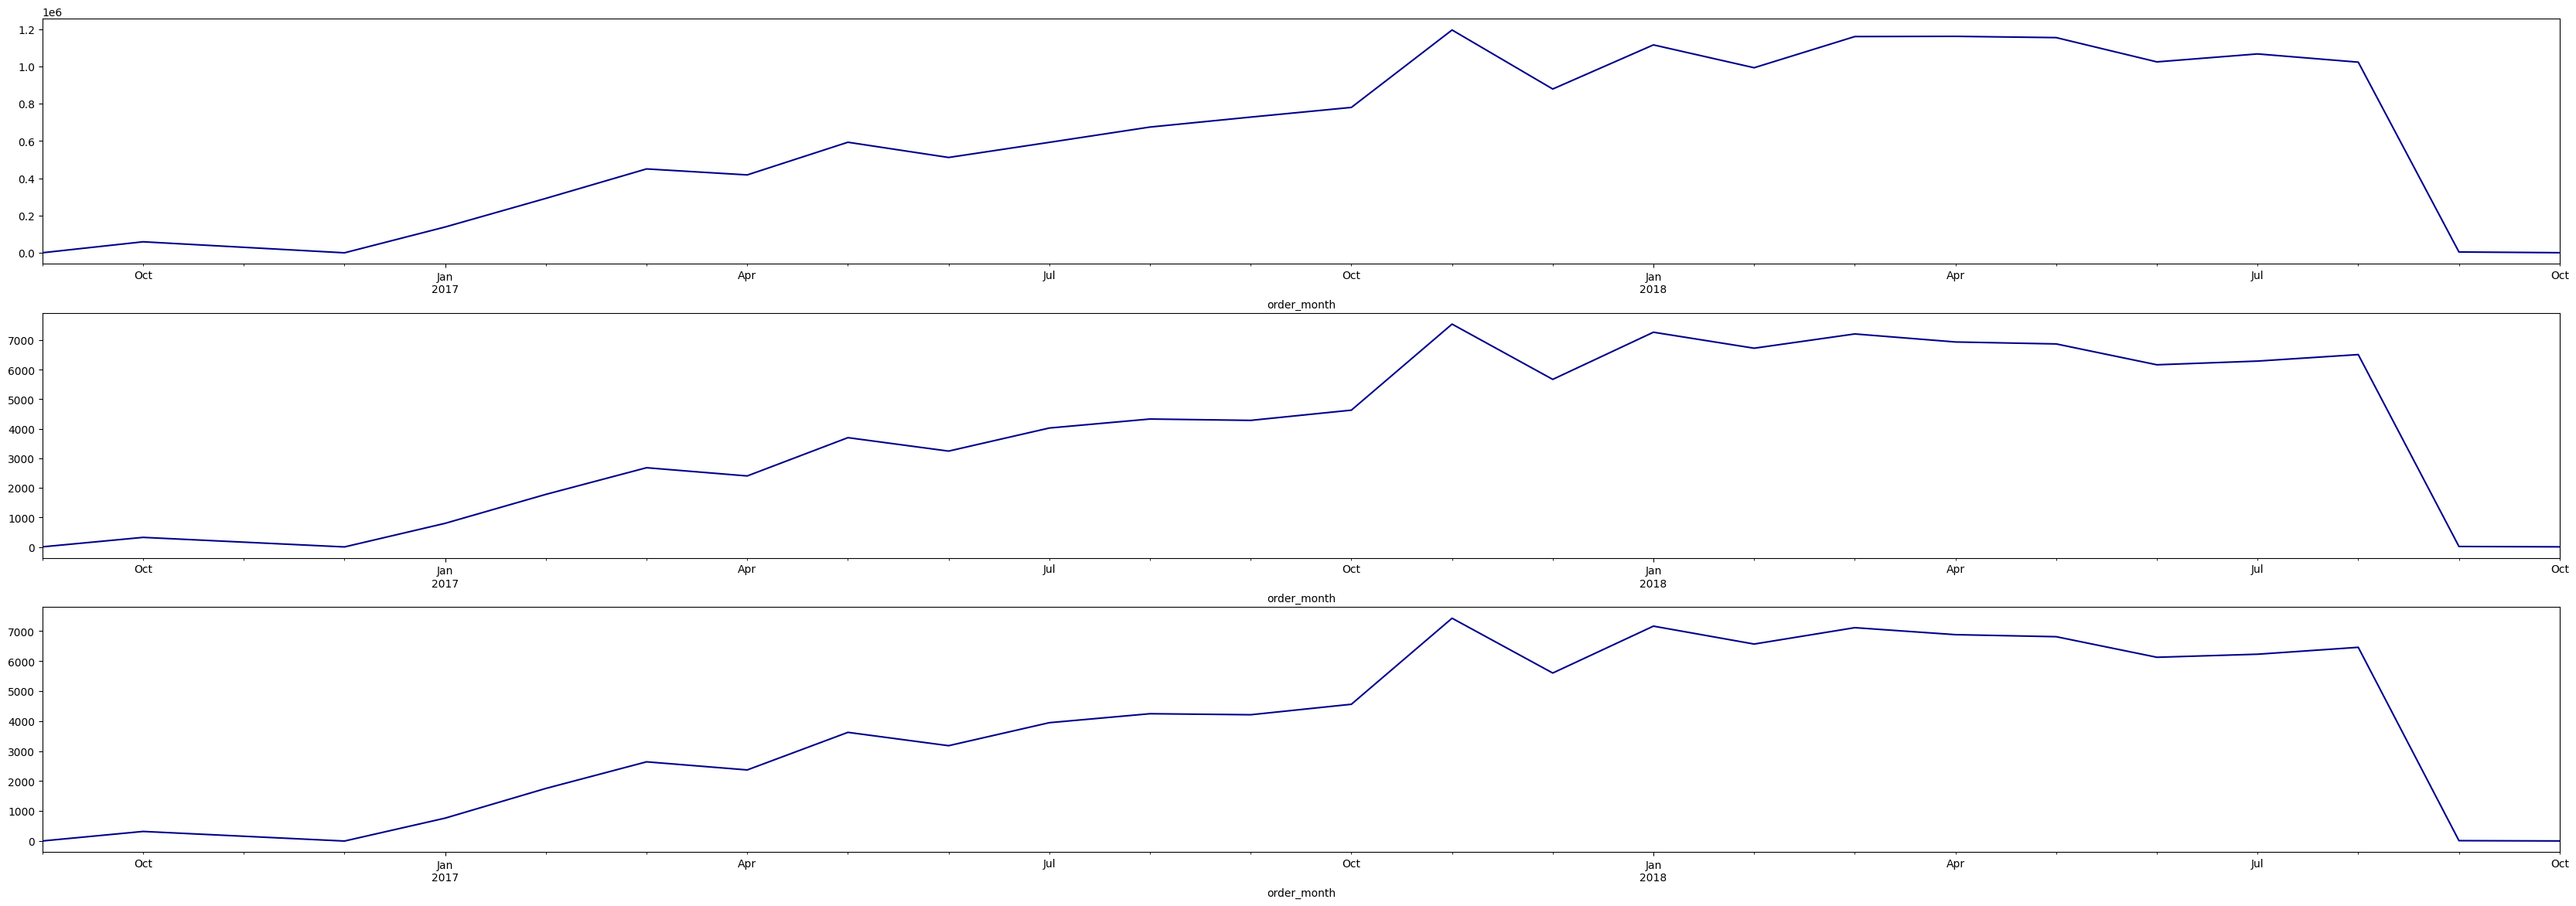

In [84]:
# buat visualisasi
fig, axes = plt.subplots(3,1, figsize=(42, 14))
dfTrend['revenue'].plot(kind='line', color='darkblue', ax=axes[0])
dfTrend['n_orders'].plot(kind='line', color='darkblue', ax=axes[1])
dfTrend['n_customers'].plot(kind='line', color='darkblue', ax=axes[2]);

> - Berdasarkan line chart diatas, dapat dilihat bahwa *revenue* Olist memiliki trend naik setiap bulannya 
> - Hal tersebut disebabkan karena adanya peningkatan order, korelasi bisa dilihat dari pola line chart *order* memiliki kemiripan dengan line chart *revenue*
> - Peningkatan order ini disebabkan karena ada peningkatan jumlah customer yang berbelanja tiap bulannya

#### **Sales berdasarkan State**

In [85]:
# buat data untuk analisis top revenue, order, dan jumlah customer berdasarkan state
dfRev = data_eda.query('order_status != "canceled" or order_status != "unavailable"').drop_duplicates(subset=['order_id','order_purchase_timestamp','payment_sequential','payment_value'], keep='first').groupby('customer_state')['price'].sum()
dfOrd = data_eda.groupby('customer_state')['order_id'].nunique()
dfCust = data_eda.groupby('customer_state')['customer_unique_id'].nunique()

dfState = pd.concat([dfRev,dfOrd,dfCust], axis=1).reset_index().rename(columns={"price": "revenue", "order_id": "n_orders", "customer_unique_id": "n_customers", 'customer_state':'state'})

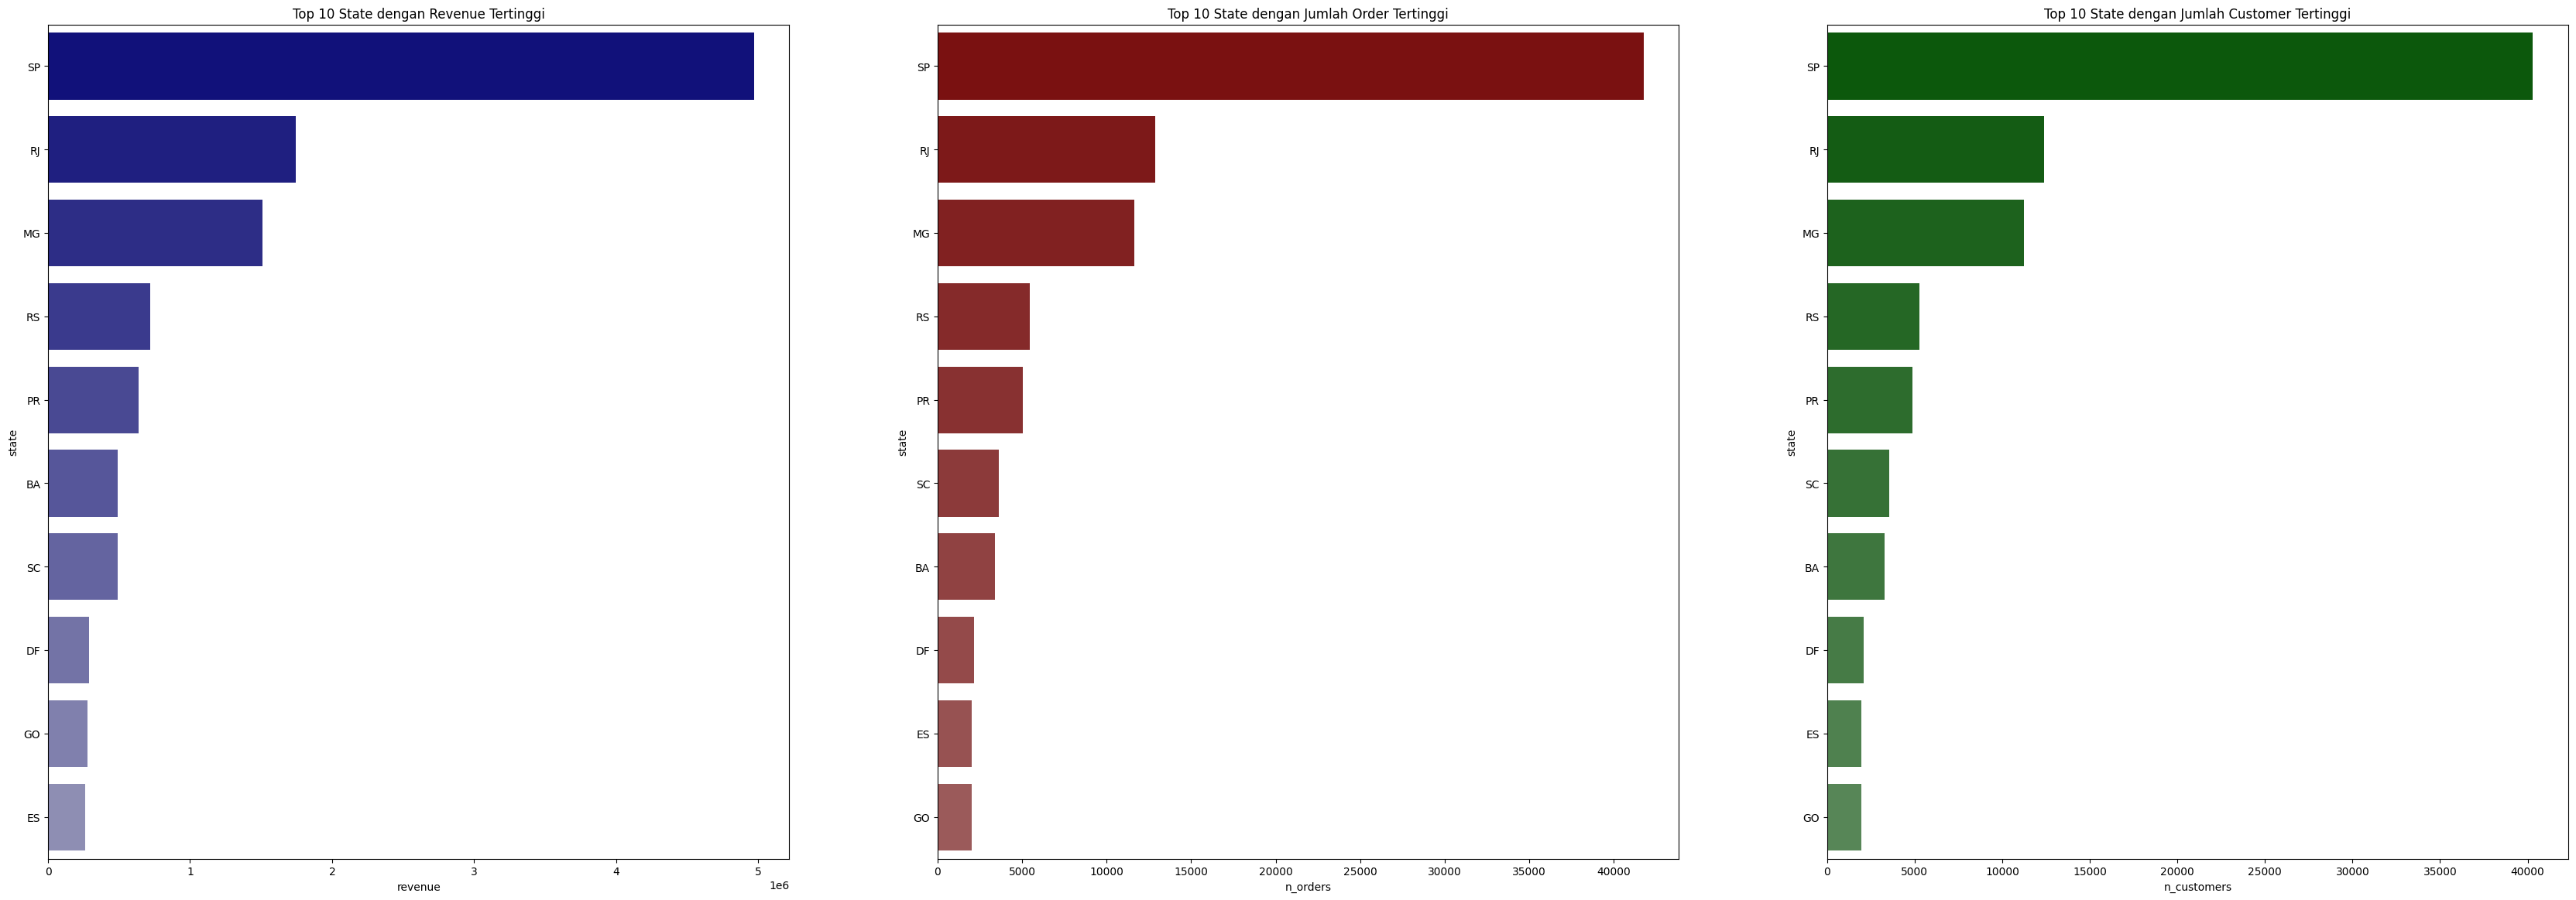

In [86]:
# Visualisasi
c1 = sns.blend_palette(['darkblue', 'lightgrey'], 15)
c2 = sns.blend_palette(['darkred', 'lightgrey'], 25)
c3 = sns.blend_palette(['darkgreen', 'lightgrey'], 25)

fig, axes = plt.subplots(1,3, figsize=(42, 14))
sns.barplot(data=dfState.nlargest(10, columns='revenue'), x = 'revenue', y='state', palette=c1, ax=axes[0])
sns.barplot(data=dfState.nlargest(10, columns='n_orders'), x = 'n_orders', y='state', palette=c2, ax=axes[1])
sns.barplot(data=dfState.nlargest(10, columns='n_customers'), x = 'n_customers', y='state', palette=c3, ax=axes[2])
axes[0].title.set_text('Top 10 State dengan Revenue Tertinggi')
axes[1].title.set_text('Top 10 State dengan Jumlah Order Tertinggi')
axes[2].title.set_text('Top 10 State dengan Jumlah Customer Tertinggi')
plt.show()

> - Sao Paulo (SP) menjadi state yang memiliki revenue, jumlah order, dan jumlah customer tertinggi
> - Hal ini berarti dari tahun 2016 - 2018 terlihat bahwa Sao Paulo menjadi state pusat konsumen Olist
> - Berdasarkan domain knowlegde hal tersebut cukup beralasan karena Sao Paulo merupakan state dengan populasi dan GDP terbanyak di Brazil *[[Source]](https://en.wikipedia.org/wiki/Federative_units_of_Brazil#List)*

#### **Sales berdasarkan Produk**

In [87]:
# buat data untuk analisis top revenue, order, dan jumlah customer berdasarkan produk
dfRev = data_eda.query('order_status != "canceled" or order_status != "unavailable"').drop_duplicates(subset=['order_id','order_purchase_timestamp','payment_sequential','payment_value'], keep='first').groupby('product_category_name_english')['price'].sum()
dfOrd = data_eda.groupby('product_category_name_english')['order_id'].nunique()
dfCust = data_eda.groupby('product_category_name_english')['customer_unique_id'].nunique()

dfProd = pd.concat([dfRev,dfOrd,dfCust], axis=1).reset_index().rename(columns={"price": "revenue", "order_id": "n_orders", "customer_unique_id": "n_customers", 'product_category_name_english':'product'})

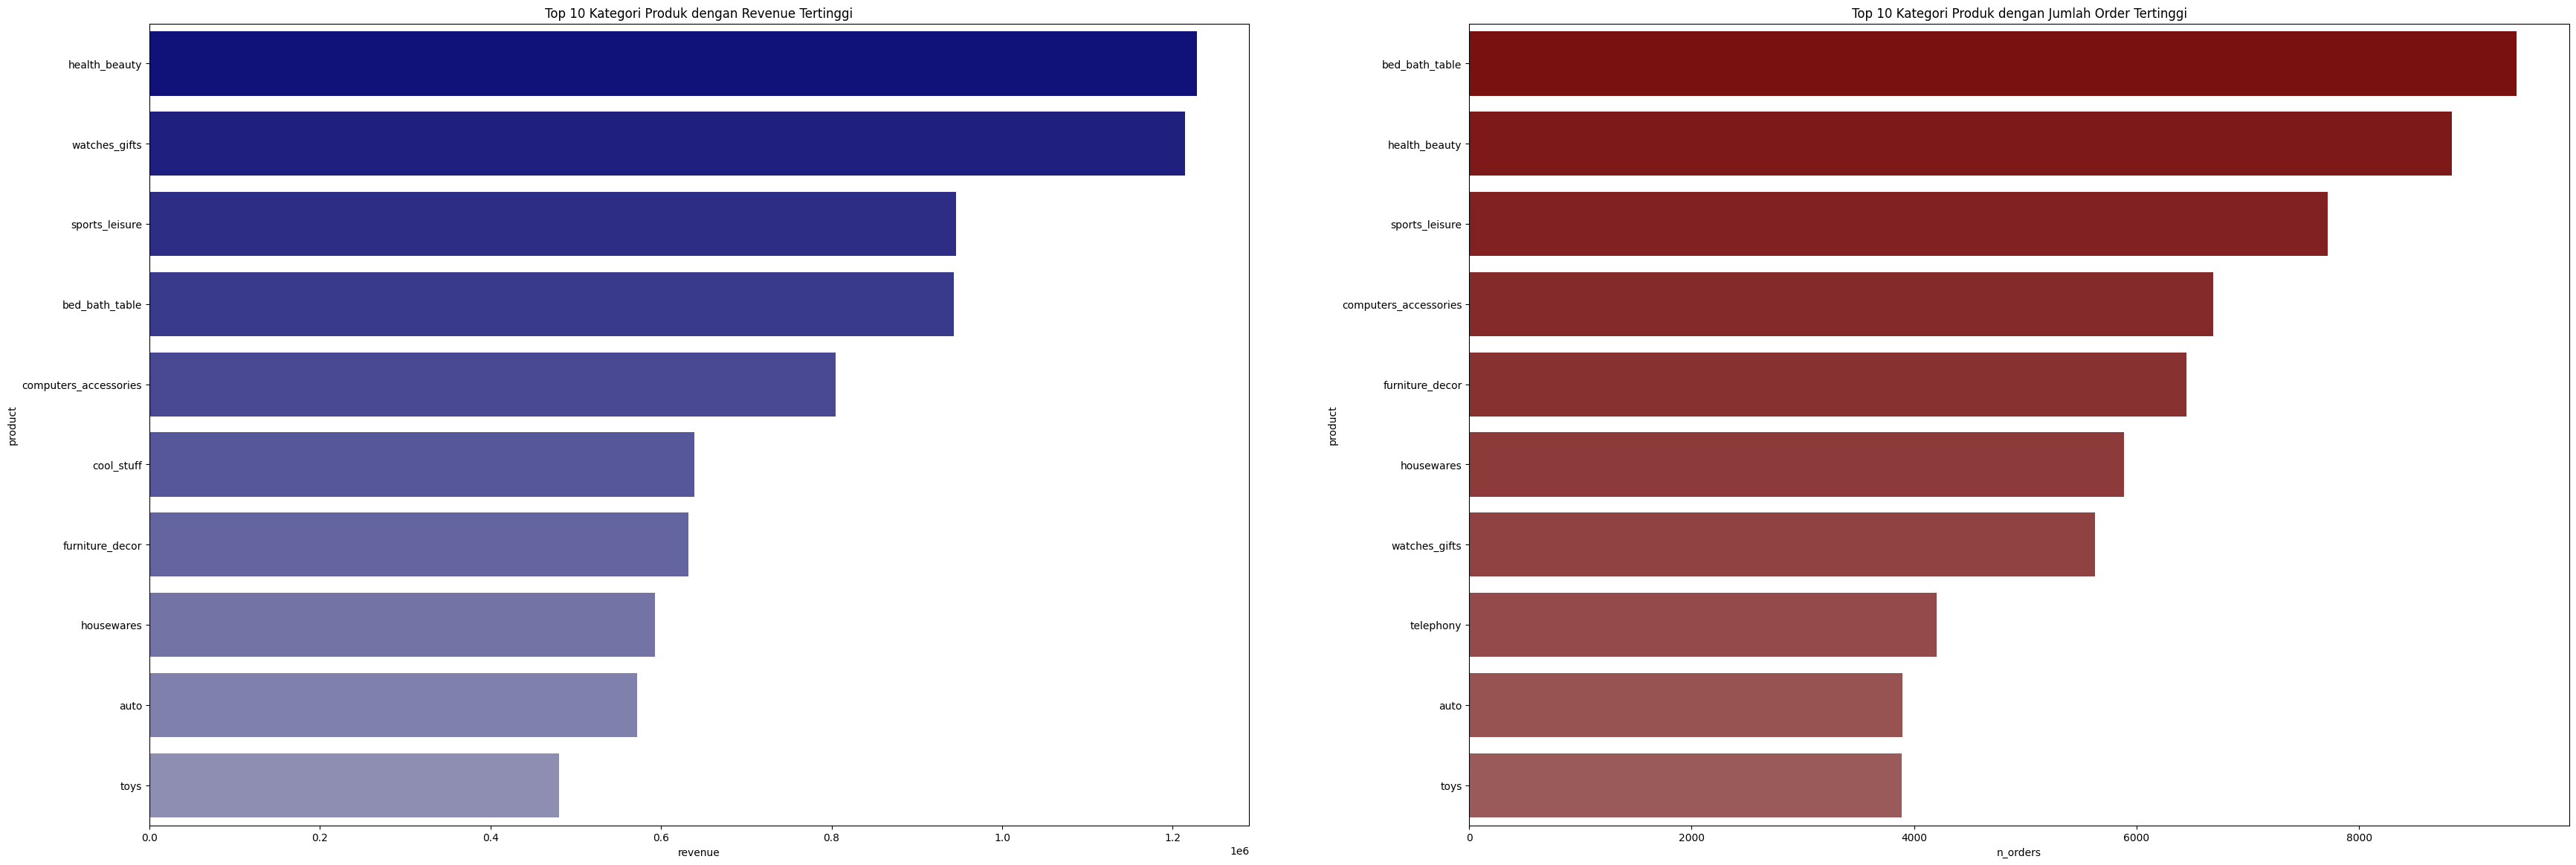

In [88]:
# Visualisasi
c1 = sns.blend_palette(['darkblue', 'lightgrey'], 15)
c2 = sns.blend_palette(['darkred', 'lightgrey'], 25)

fig, axes = plt.subplots(1,2, figsize=(42, 14))
sns.barplot(data=dfProd.nlargest(10, columns='revenue'), x = 'revenue', y='product', palette=c1, ax=axes[0])
sns.barplot(data=dfProd.nlargest(10, columns='n_orders'), x = 'n_orders', y='product', palette=c2, ax=axes[1])

axes[0].title.set_text('Top 10 Kategori Produk dengan Revenue Tertinggi')
axes[1].title.set_text('Top 10 Kategori Produk dengan Jumlah Order Tertinggi')

plt.show()

> - Berdasarkan revenue, health_beauty merupakan kategori produk dengan revenue tertinggi
> - Berdasarkan jumlah order, bed_bath_table merupakan kategori produk dengan revenue tertinggi

#### **Customer Behaviour**

##### **Waktu Pembelian**

In [89]:
# buat fitur baru order_hour, day_of_week, dan day_name
data_eda['order_hour'] = data_eda['order_purchase_timestamp'].dt.strftime('%H').astype('int')
data_eda['day_of_week'] = data_eda['order_purchase_timestamp'].dt.day_of_week
data_eda['day_name'] = data_eda['day_of_week'].map({ 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday' })

# buat dataset dfTime yang berisi waktu pembelian dan jumlah customer
dfTime = data_eda.drop_duplicates(subset='order_id').groupby(by=['order_hour','day_of_week','day_name'])['order_id'].nunique().reset_index()

# buat pivot table dari dfTime
timePur = dfTime.pivot_table(values='order_id', index='order_hour', columns=['day_of_week','day_name'],aggfunc='sum')

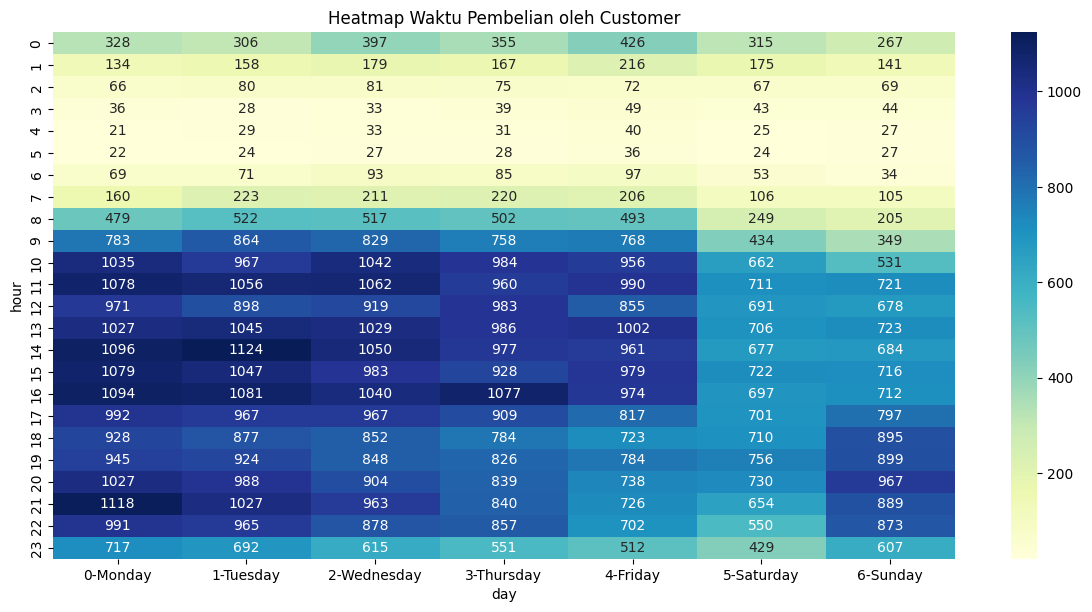

In [90]:
# buat visualisasi heatmap
plt.figure(figsize=(12,6))

sns.heatmap(timePur,
            annot=True,
            fmt='g',
            cmap='YlGnBu',)

plt.tight_layout()
plt.xlabel('day')
plt.ylabel('hour')
plt.title('Heatmap Waktu Pembelian oleh Customer')
plt.show()

> - Berdasarkan heatmap diatas, customer olist paling banyak berbelanja pada hari senin dan selasa
> - Secara umum, waktu yang paling diminati untuk berbelanja adalah dari jam 10 pagi sampai 10 malam

##### **Tipe Pembayaran**

In [91]:
# buat data untuk analisis top order berdasrakan tipe pembayaran
dfPay = data_eda.groupby('payment_type')['order_id'].nunique()
dfPay = dfPay.sort_values(ascending=False).reset_index().rename(columns={'order_id': 'n_orders'})

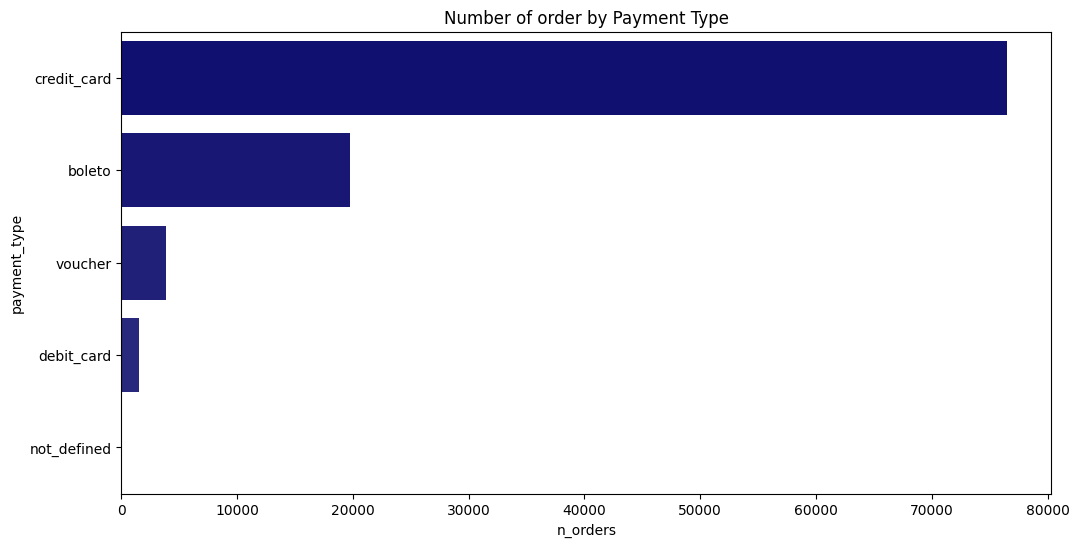

In [92]:
color_palette = sns.blend_palette(['navy', 'lightgrey'], 25)

# Visualisasi
plt.figure(figsize=(12,6))
sns.barplot(data=dfPay, x = 'n_orders', y='payment_type', palette=color_palette)
plt.title(f'Number of order by Payment Type')
plt.show()

> - Kebanyakan customer membayar menggunakan credit_card

##### **Installment**

In [93]:
data_eda['installment_type'] = data_eda['payment_installments'].apply(lambda x: 'lunas' if x > 1 else 'cicilan')

In [94]:
insType = data_eda.groupby('installment_type')['order_id'].nunique()
insType

installment_type
cicilan    49063
lunas      51170
Name: order_id, dtype: int64

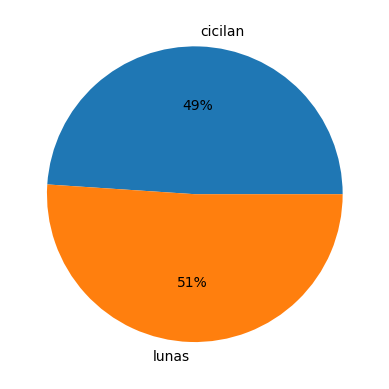

In [95]:
plt.pie(insType, labels=insType.index, autopct='%.0f%%');

> - Tidak ada perbedaan yang signifikan antara pembayaran secara cicilan dan lunas

#### **Customer Retention**

##### **Retention Rate**

In [96]:
dfCohort = data_eda.drop_duplicates(subset='order_id', keep='first')[['customer_unique_id', 'order_month']]
dfCohort['cohort_month'] = dfCohort.groupby('customer_unique_id')['order_month'].transform('min')
dfCohort.head()

,customer_unique_id,order_month,cohort_month
0,b7d76e111c89f7ebf14761390f0f7d17,2016-09,2016-09
2,4854e9b3feff728c13ee5fc7d1547e92,2016-09,2016-09
3,009b0127b727ab0ba422f6d9604487c7,2016-09,2016-09
4,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09,2016-09
5,0eb1ee9dba87f5b36b4613a65074337c,2016-10,2016-10


In [97]:
# Number of distinct customer
dfCohort = dfCohort.groupby(['order_month','cohort_month'])\
            .agg(n_customers = ('customer_unique_id', 'nunique'))\
            .reset_index(drop=False)

# Period = current month - cohort month
dfCohort['period'] = (dfCohort['order_month'] - dfCohort['cohort_month']).apply(attrgetter('n'))

dfCohort.head()

,order_month,cohort_month,n_customers,period
0,2016-09,2016-09,4,0
1,2016-10,2016-10,321,0
2,2016-12,2016-12,1,0
3,2017-01,2016-12,1,1
4,2017-01,2017-01,764,0


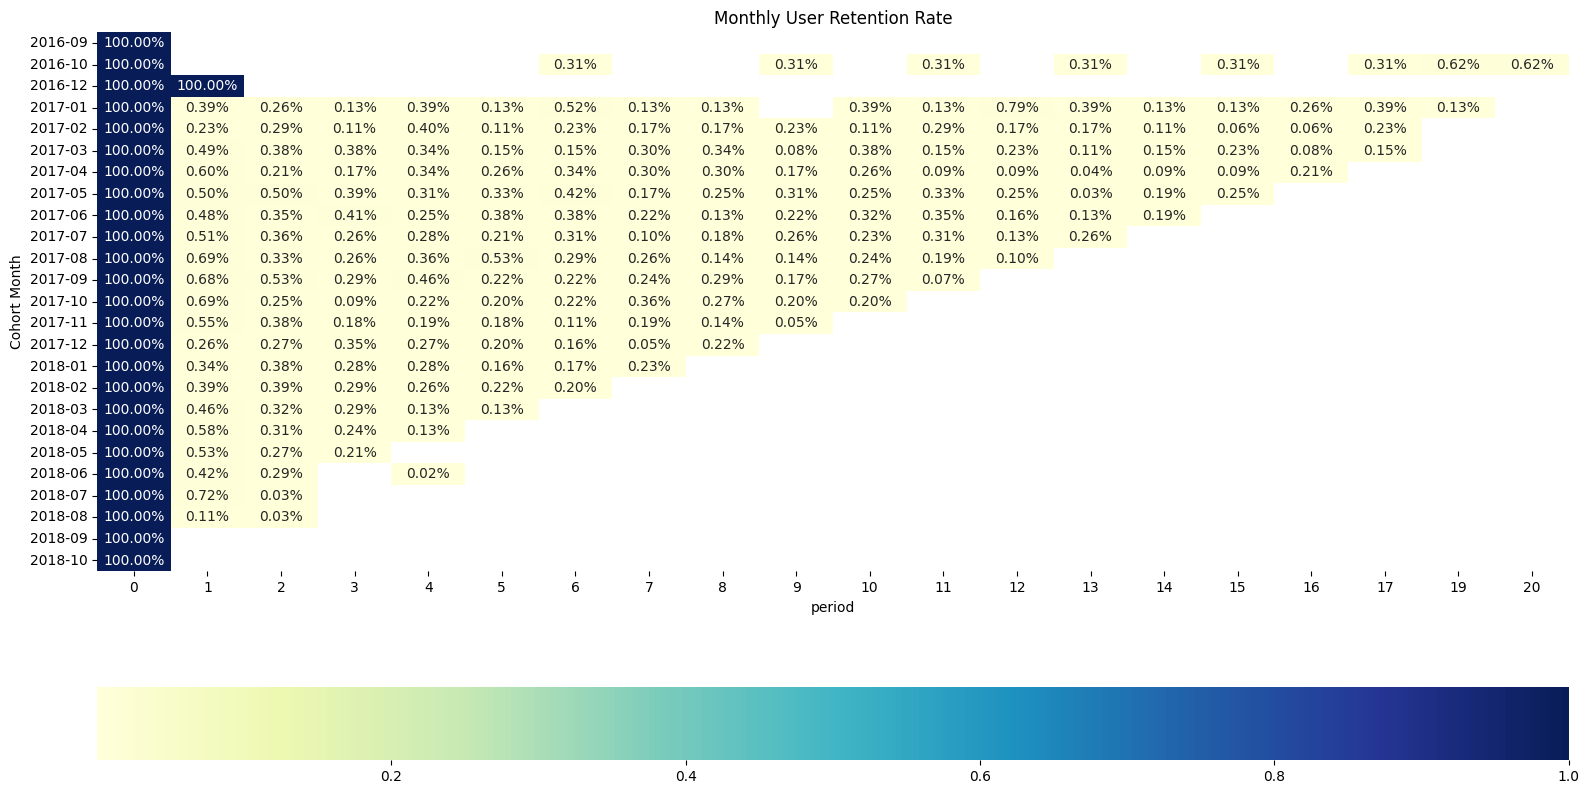

In [98]:
# Pivot Cohort
pivot_cohort = dfCohort.pivot_table(index='cohort_month', columns='period', values='n_customers')
pivot_cohort = pivot_cohort.divide(pivot_cohort[0], axis=0)

plt.figure(figsize=(16,8))
sns.heatmap(pivot_cohort,
            annot=True,
            fmt='.2%',
            cmap='YlGnBu',
            cbar_kws={'orientation':'horizontal'})
plt.tight_layout()
plt.xlabel('period')
plt.ylabel('Cohort Month')
plt.title('Monthly User Retention Rate')
plt.show()

> - Berdasarkan heatmap diatas, dapat dilihat bahwa secara umum retention rate konsumen sangat rendah, bahkan tidak sampai 1% 

##### **Customer**

In [99]:
dfOrd = data_eda.groupby('customer_unique_id')['order_id'].nunique().reset_index().rename(columns={'order_id': 'n_orders'})
dfOrd['orders_remarks'] = dfOrd['n_orders'].apply(lambda x: '> 1 orders' if x > 1 else '1 order')
dfOrd.nlargest(5, columns='n_orders')

,customer_unique_id,n_orders,orders_remarks
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17,> 1 orders
23472,3e43e6105506432c953e165fb2acf44c,9,> 1 orders
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7,> 1 orders
37797,6469f99c1f9dfae7733b25662e7f1782,7,> 1 orders
76082,ca77025e7201e3b30c44b472ff346268,7,> 1 orders


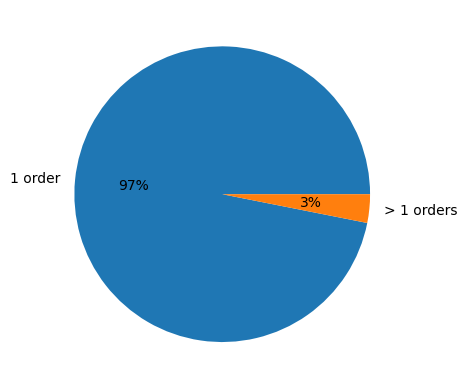

In [100]:
ordRem = dfOrd['orders_remarks'].value_counts()

plt.pie(ordRem, labels=ordRem.index, autopct='%.0f%%');

> - Jika dilihat proporsinya, bahkan hanya 3% dari total customer yang melakukan order > 1 kali